In [0]:
from keras.applications.vgg19 import VGG19,preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam,SGD
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import backend as k 
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
img_width, img_height = 256, 256
train_dir = '/content/drive/My Drive/mobile_gallery_image_classification/train'
val_dir = '/content/drive/My Drive/mobile_gallery_image_classification/validation'
nb_train_samples = 1735
nb_validation_samples = 639
batch_size = 16
epochs = 20
model = VGG19(weights = "imagenet", include_top=False, input_shape = (img_width, img_height, 3))


In [0]:
train_datagen = ImageDataGenerator(
rescale = 1./255,
horizontal_flip = True,
fill_mode = "nearest",
zoom_range = 0.3,
width_shift_range = 0.3,
height_shift_range=0.3,
rotation_range=30)

valid_datagen = ImageDataGenerator(
rescale = 1./255,
horizontal_flip = True,
fill_mode = "nearest",
zoom_range = 0.3,
width_shift_range = 0.3,
height_shift_range=0.3,
rotation_range=30)

In [0]:
train_generator = train_datagen.flow_from_directory(train_dir,target_size=(img_height,img_width),batch_size=batch_size,seed=42)
valid_generator = valid_datagen.flow_from_directory(val_dir,target_size=(img_height,img_width),batch_size=batch_size,seed=42)

Found 1735 images belonging to 10 classes.
Found 639 images belonging to 10 classes.


In [0]:
def build_finetune_model(base_model, num_classes):
    
    for layer in model.layers[:5]:
      layer.trainable = False

    x = model.output
    x = Flatten()(x)
    x = Dense(1024,activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(1024,activation='relu')(x)
    predictions = Dense(num_classes,activation='softmax')(x)
    
    finetune_model = Model(inputs=model.input, outputs=predictions)

    return finetune_model

class_list = ["Food", "Gods", "Greetings","Group_pics","Memes","Notes","Selfies","Telugu_quotes","Temples","Whatsapp_Screeshots"]


finetune_model = build_finetune_model(model,num_classes=len(class_list))


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:

adam = Adam(lr=0.00001)
finetune_model.compile(adam, loss='categorical_crossentropy', metrics=['accuracy'])

filepath="/content/drive/My Drive/checkpoints/" + "VGG19" + "_model_weights.h5"
checkpoint = ModelCheckpoint(filepath, monitor=["acc"], verbose=1, mode='max')
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=10, verbose=1, mode='auto')
callbacks_list = [checkpoint,early]

history = finetune_model.fit_generator(train_generator, epochs=epochs, 
                                       steps_per_epoch=nb_train_samples // batch_size, 
                                       validation_data = valid_generator,validation_steps=nb_validation_samples//batch_size,
                                       shuffle=True, callbacks=callbacks_list)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/20
108/108 [==============================] - 48s 440ms/step - loss: 1.7631 - acc: 0.3682 - val_loss: 1.0723 - val_acc: 0.6458

Epoch 00001: saving model to /content/drive/My Drive/checkpoints/VGG19_model_weights.h5
Epoch 2/20
108/108 [==============================] - 47s 435ms/step - loss: 0.8246 - acc: 0.7222 - val_loss: 0.7036 - val_acc: 0.7833

Epoch 00002: saving model to /content/drive/My Drive/checkpoints/VGG19_model_weights.h5
Epoch 3/20
108/108 [==============================] - 47s 431ms/step - loss: 0.6046 - acc: 0.8106 - val_loss: 0.4792 - val_acc: 0.8411

Epoch 00003: saving model to /content/drive/My Drive/checkpoints/VGG19_model_weights.h5
Epoch 4/20
108/108 [==============================] - 46s 424ms/step - loss: 0.5218 - acc: 0.8272 - val_loss: 0.6575 - val_acc: 0.7849

Epoch 00004: saving model to /content/drive/My Drive/checkpoints/VGG19_model_weights.h5
Epoch 

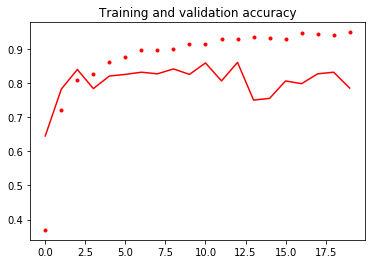

<Figure size 432x288 with 0 Axes>

In [0]:
import matplotlib.pyplot as plt

def plot_training(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, 'r.')
    plt.plot(epochs, val_acc, 'r')
    plt.title('Training and validation accuracy')

    # plt.figure()
    # plt.plot(epochs, loss, 'r.')
    # plt.plot(epochs, val_loss, 'r-')
    # plt.title('Training and validation loss')
    plt.show()

    plt.savefig('acc_vs_epochs.png')

plot_training(history)

In [0]:
import cv2
import numpy as np
import os


In [0]:
def predict(image):
    class_list = ["Food", "Gods", "Greetings","Group_pics","Memes","Notes","Selfies","Telugu_quotes","Temples","Whatsapp_Screeshots"]
    im = cv2.imread(image)
    im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), (256, 256)).astype(np.float32) / 255.0
    im = np.expand_dims(im, axis =0)
    pred = finetune_model.predict(im)
    index = np.argmax(pred)

    return class_list[index]

    #return img.shape

In [0]:
img_dir = '/content/drive/My Drive/mobile_gallery_image_classification/test'
for img in os.listdir(img_dir):
    print(img,end=" ")
    print(predict(os.path.join(img_dir,img)))

00000025.jpg Group_pics
food.jpg Food
greetings.jpg Greetings
god.jpg Gods
quote.jpg Telugu_quotes
temple.jpg Temples
notes.jpg Notes
